## Run SCARP to get cell and peak embedding of 10X-pbmc-ATAC data

In [1]:
import sys
sys.path.append('../Scarp/')

from downstream import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(1)
random_state = 1
beta = 5000
m = 1.5
merge_thre = 3000

In [3]:
# data_type = '10X_pbmc_ATAC'
data_type = '10X_pbmc_ATAC_celltype_filtered'

In [4]:
data = sc.read_h5ad('./Processed data/' + data_type + '.h5ad')
sc.pp.filter_genes(data, min_cells=1)

In [11]:
from help_func import *
data = filter_cells(data, data.obs[data.obs['celltype']=='CD4 Naive'].index)

In [12]:
sc.pp.filter_genes(data, min_cells=1)

In [26]:
data.write('./Processed data/10X_pbmc_ATAC_celltype_filtered_CD4_Naive.h5ad')

In [13]:
Cells = data.obs.index
Peaks = data.var.index
Cells_num, Peaks_num = data.X.shape
N = Cells_num + Peaks_num
labels = data.obs['celltype'].astype('category')
cluster_num = np.unique(labels).shape[0]
print('Number of Peaks:', Peaks_num)
print('Number of Cells:', Cells_num)
print('Number of labels: ', cluster_num)

Number of Peaks: 101472
Number of Cells: 1405
Number of labels:  1


In [14]:
t, diffusion_mat = SCARP(data=data,
                         m=m,
                         merge_thre=merge_thre,
                         beta=beta,
                         peak_loc=True)


%%%%%%%%%%%%%%%%%%%%%%% Diffusion Started (with 23 cores parallel computing)%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Finished %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Running time: 411.6596095561981s

Matrix Splicing...........
Splicing time: 11.32630205154419s


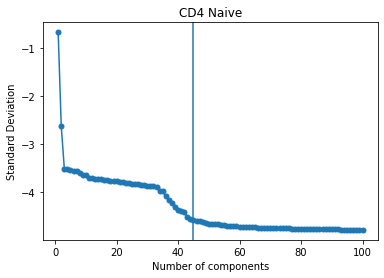

In [15]:
k = std_plot(data=diffusion_mat,
             title='CD4 Naive',
             max_k=100,
             plot_std=True,
             save_file='./Results/CD4 Naive.svg')

In [20]:
cell_embedding = SCARP_cell_embedding(diffusion_mat=diffusion_mat,
                                      kept_comp=40)

Cells_df = pd.DataFrame(cell_embedding,
                        index=Cells,
                        columns=['feature' + str(i + 1) for i in range(cell_embedding.shape[1])])

In [24]:
Cells_df.to_csv('./Results/' + data_type + '_SCARP_Cells_feature_CD4_Naive.csv')

In [21]:
adata_cell = sc.AnnData(Cells_df)
adata_cell.var_names_make_unique()
adata_cell.obs['label'] = labels

In [22]:
sc.pp.neighbors(adata_cell, use_rep='X', random_state=random_state)
sc.tl.umap(adata_cell, random_state=random_state)

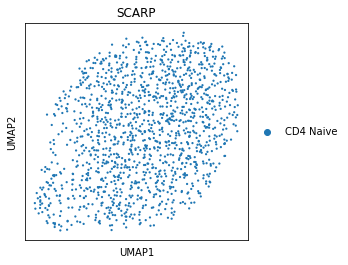

<Figure size 432x288 with 0 Axes>

In [23]:
fig1, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata_cell, color='label', title='SCARP', s=20, ax=ax, save=data_type + 'label.svg')
plt.subplots_adjust(right=0.55)

In [25]:
peaks_embedding = SCARP_cell_embedding(diffusion_mat[:, Cells_num:].T, 40)
Peaks_df = pd.DataFrame(peaks_embedding,
                        index=Peaks,
                        columns=['feature' + str(i + 1) for i in range(peaks_embedding.shape[1])])
Peaks_df.to_csv('./Results/' + data_type + '_SCARP_Peaks_feature_CD4_Naive.csv')